# **Neural Evolution for Handwritten Digit Recognition**

Using:-
*   Differential Evolution
*   Differential Evolution + Genetic Algorithms
*   Backpropagation


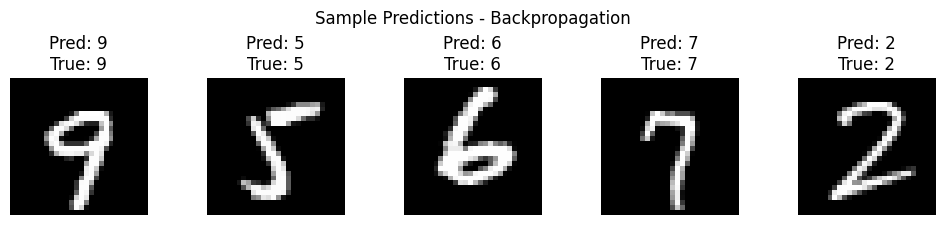

---



# Install dependencies in Google Colab

In [ ]:
!pip install tensorflow deap streamlit pyngrok numpy matplotlib seaborn pandas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


# Mount Google Drive for saving outputs

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import streamlit as st
from pyngrok import ngrok
import os
import time

# Set random seed for reproducibility

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_flat = x_train.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Use a validation subset for DE fitness evaluation

In [ ]:
val_size = 2000
x_val_flat = x_train_flat[:val_size]
y_val = y_train[:val_size]
x_train_flat = x_train_flat[val_size:]
y_train = y_train[val_size:]


#Neural network parameters

In [ ]:
input_size = 784
hidden_size = 128
output_size = 10
dim = (input_size * hidden_size + hidden_size) + (hidden_size * output_size + output_size)
print(f"Total parameters to optimize: {dim}")

Total parameters to optimize: 101770


# Activation functions

In [ ]:
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def softmax(x):
    """Softmax activation function"""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

# Neural network layer

In [ ]:
class Layer:
    def __init__(self, input_units, output_units, activation_function=None):
        self.W = np.random.uniform(-1, 1, (input_units, output_units))
        self.b = np.random.uniform(-1, 1, (output_units))
        self.activation_function = activation_function

    def forward(self, inputs):
        z = np.dot(inputs, self.W) + self.b
        return self.activation_function(z) if self.activation_function else z

# Neural network model

In [ ]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

# Weight manipulation functions

In [ ]:
def gen_individual():
    """Generate a neural network with random weights"""
    layers = [
        Layer(input_size, hidden_size, relu),
        Layer(hidden_size, output_size, softmax)
    ]
    return NeuralNetwork(layers)

In [ ]:
def flatten_weights(nn):
    """Convert neural network weights to a flat array"""
    flat = []
    for layer in nn.layers:
        flat.extend(layer.W.flatten())
        flat.extend(layer.b)
    return np.array(flat)

In [ ]:
def unflatten_weights(flat):
    """Convert flat array back to neural network weights"""
    nn = gen_individual()
    idx = 0
    for layer in nn.layers:
        w_shape = layer.W.shape
        b_shape = layer.b.shape
        w_size = np.prod(w_shape)
        b_size = np.prod(b_shape)
        layer.W = flat[idx:idx+w_size].reshape(w_shape)
        idx += w_size
        layer.b = flat[idx:idx+b_size]
        idx += b_size
    return nn

# Fitness evaluation

In [ ]:
def evaluate(ind, x, y):
    """Evaluate fitness as accuracy on given dataset"""
    model = unflatten_weights(ind)
    preds = model.predict(x)
    return accuracy_score(y, preds)

# Diversity preservation

In [ ]:
def fitness_sharing(fitness, population, sigma=0.1):
    """Fitness sharing to maintain population diversity"""
    shared_fitness = np.copy(fitness)
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            dist = np.linalg.norm(population[i] - population[j])
            if dist < sigma:
                sharing = 1 - dist / sigma
                shared_fitness[i] /= (1 + sharing)
                shared_fitness[j] /= (1 + sharing)
    return shared_fitness

# DE mutation strategies

In [ ]:
def de_mutation(population, i, F, fitness, strategy='rand/1'):
    idxs = [j for j in range(len(population)) if j != i]
    if strategy == 'rand/1':
        a, b, c = population[np.random.choice(idxs, 3, replace=False)]
        mutant = np.clip(a + F * (b - c), -1, 1)
    elif strategy == 'best/1':
        best_idx = np.argmax(fitness)
        a, b = population[np.random.choice(idxs, 2, replace=False)]
        mutant = np.clip(population[best_idx] + F * (a - b), -1, 1)
    return mutant

# DE crossover strategies

In [ ]:
def de_crossover(trial, target, CR, strategy='binomial'):
    if strategy == 'binomial':
        cross_points = np.random.rand(dim) < CR
        return np.where(cross_points, trial, target)
    elif strategy == 'exponential':
        n = np.random.randint(0, dim)
        L = 0
        while np.random.rand() < CR and L < dim:
            L += 1
        indices = [(n + i) % dim for i in range(L)]
        result = target.copy()
        for idx in indices:
            result[idx] = trial[idx]
        return result

# Self-adaptive DE (for bonus marks)

In [ ]:
def self_adaptive_de(population, fitness, x_val, y_val, F_base=0.8, CR_base=0.9):
    new_population = []
    new_fitness = []
    F = np.random.normal(F_base, 0.1, len(population))
    CR = np.random.normal(CR_base, 0.1, len(population))
    F = np.clip(F, 0.1, 1.0)
    CR = np.clip(CR, 0.1, 1.0)
    shared_fitness = fitness_sharing(fitness, population)
    for i in range(len(population)):
        mutant = de_mutation(population, i, F[i], shared_fitness, 'rand/1')
        trial = de_crossover(mutant, population[i], CR[i], 'binomial')
        trial_fit = evaluate(trial, x_val, y_val)
        if trial_fit >= fitness[i]:
            new_population.append(trial)
            new_fitness.append(trial_fit)
        else:
            new_population.append(population[i])
            new_fitness.append(fitness[i])
    return np.array(new_population), np.array(new_fitness)

# Pure DE algorithm

In [ ]:
def pure_de(pop_size, gens, F, CR, mutation_strategy, crossover_strategy, seed, x_val, y_val):
    np.random.seed(seed)
    population = np.random.uniform(-0.5, 0.5, (pop_size, dim))
    fitness = np.array([evaluate(ind, x_val, y_val) for ind in population])
    best_ind = population[np.argmax(fitness)].copy()
    best_fitness = np.max(fitness)
    history = []
    for gen in range(gens):
        population, fitness = self_adaptive_de(population, fitness, x_val, y_val, F, CR)
        if np.max(fitness) > best_fitness:
            best_ind = population[np.argmax(fitness)].copy()
            best_fitness = np.max(fitness)
        history.append(best_fitness)
        if gen % 10 == 0:
            print(f"Generation {gen}: Best Accuracy = {best_fitness:.4f}")
    test_acc = evaluate(best_ind, x_test_flat, y_test)
    return history, test_acc, best_ind


# GA components for hybrid approach

In [ ]:
def tournament_selection(fitness, k=3):
    selected = np.random.choice(len(fitness), k)
    return selected[np.argmax(fitness[selected])]

def uniform_crossover(parent1, parent2):
    mask = np.random.rand(len(parent1)) < 0.5
    return np.where(mask, parent1, parent2)

def mutate(ind, mutation_rate=0.05, mutation_strength=0.2):
    mutation_mask = np.random.rand(len(ind)) < mutation_rate
    noise = np.random.normal(0, mutation_strength, len(ind))
    ind[mutation_mask] += noise[mutation_mask]
    return np.clip(ind, -1, 1)

# Hybrid DE+GA algorithm

In [ ]:
def hybrid_de_ga(pop_size, gens, F, CR, mutation_strategy, crossover_strategy, seed, x_val, y_val):
    np.random.seed(seed)
    population = np.random.uniform(-0.5, 0.5, (pop_size, dim))
    fitness = np.array([evaluate(ind, x_val, y_val) for ind in population])
    best_ind = population[np.argmax(fitness)].copy()
    best_fitness = np.max(fitness)
    history = []
    for gen in range(gens):
        # DE component
        new_population = []
        new_fitness = []
        shared_fitness = fitness_sharing(fitness, population)
        for i in range(pop_size):
            mutant = de_mutation(population, i, F, shared_fitness, mutation_strategy)
            trial = de_crossover(mutant, population[i], CR, crossover_strategy)
            trial_fit = evaluate(trial, x_val, y_val)
            # GA component
            p1_idx = tournament_selection(fitness)
            p2_idx = tournament_selection(fitness)
            child = uniform_crossover(population[p1_idx], population[p2_idx])
            child = mutate(child)
            child_fit = evaluate(child, x_val, y_val)
            # Survival selection
            candidates = [population[i], trial, child]
            scores = [fitness[i], trial_fit, child_fit]
            best_candidate = candidates[np.argmax(scores)]
            best_score = np.max(scores)
            new_population.append(best_candidate)
            new_fitness.append(best_score)
            if best_score > best_fitness:
                best_fitness = best_score
                best_ind = best_candidate.copy()
        population = np.array(new_population)
        fitness = np.array(new_fitness)
        history.append(best_fitness)
        if gen % 10 == 0:
            print(f"Generation {gen}: Best Accuracy = {best_fitness:.4f}")
    test_acc = evaluate(best_ind, x_test_flat, y_test)
    return history, test_acc, best_ind

# Multiple Experiment Setup (for bonus marks)

In [ ]:
experiments = [
    {"name": "Rand/1, Pop50, Binomial", "pop_size": 50, "gens": 200, "F": 0.8, "CR": 0.9, "mutation": "rand/1", "crossover": "binomial"},
    {"name": "Best/1, Pop50, Binomial", "pop_size": 50, "gens": 200, "F": 0.8, "CR": 0.9, "mutation": "best/1", "crossover": "binomial"},
    {"name": "Rand/1, Pop100, Binomial", "pop_size": 100, "gens": 200, "F": 0.8, "CR": 0.9, "mutation": "rand/1", "crossover": "binomial"},
    {"name": "Rand/1, Pop50, Exponential", "pop_size": 50, "gens": 200, "F": 0.8, "CR": 0.9, "mutation": "rand/1", "crossover": "exponential"},
    {"name": "Low F, Pop50, Binomial", "pop_size": 50, "gens": 200, "F": 0.4, "CR": 0.9, "mutation": "rand/1", "crossover": "binomial"},
]

# Run pure DE experiments

In [ ]:
print("Running Pure DE Experiments...")
de_results = []
start_time = time.time()
history_main_de, test_acc_main_de, best_ind_main_de = pure_de(
    200, 400, 0.8, 0.9, 'rand/1', 'binomial', 42, x_val_flat, y_val
)
end_time = time.time()
de_results.append({
    "Experiment": "Main DE Run",
    "Test_Accuracy": test_acc_main_de,
    "Runtime (s)": end_time - start_time,
    "History": history_main_de
})
print(f"Main DE Test Accuracy: {test_acc_main_de:.4f}, Runtime: {end_time - start_time:.2f} seconds")

for exp in experiments:
    print(f"Running DE experiment: {exp['name']}")
    start_time = time.time()
    history, test_acc, best_ind = pure_de(
        exp["pop_size"], exp["gens"], exp["F"], exp["CR"], exp["mutation"], exp["crossover"], 42, x_val_flat, y_val
    )
    end_time = time.time()
    de_results.append({
        "Experiment": exp["name"],
        "Test_Accuracy": test_acc,
        "Runtime (s)": end_time - start_time,
        "History": history
    })
    print(f"Test Accuracy: {test_acc:.4f}, Runtime: {end_time - start_time:.2f} seconds")


Running Pure DE Experiments...
Generation 0: Best Accuracy = 0.1925
Generation 10: Best Accuracy = 0.2600
Generation 20: Best Accuracy = 0.2815
Generation 30: Best Accuracy = 0.2960
Generation 40: Best Accuracy = 0.3275
Generation 50: Best Accuracy = 0.3380
Generation 60: Best Accuracy = 0.3740
Generation 70: Best Accuracy = 0.3800
Generation 80: Best Accuracy = 0.3955
Generation 90: Best Accuracy = 0.4050
Generation 100: Best Accuracy = 0.4140
Generation 110: Best Accuracy = 0.4230
Generation 120: Best Accuracy = 0.4230
Generation 130: Best Accuracy = 0.4230
Generation 140: Best Accuracy = 0.4310
Generation 150: Best Accuracy = 0.4310
Generation 160: Best Accuracy = 0.4315
Generation 170: Best Accuracy = 0.4345
Generation 180: Best Accuracy = 0.4345
Generation 190: Best Accuracy = 0.4345
Generation 200: Best Accuracy = 0.4345
Generation 210: Best Accuracy = 0.4410
Generation 220: Best Accuracy = 0.4415
Generation 230: Best Accuracy = 0.4415
Generation 240: Best Accuracy = 0.4485
Gener

# Save DE results to CSV

In [ ]:
de_results_df = pd.DataFrame(de_results)
de_results_df.to_csv('/content/drive/MyDrive/project12_de_results.csv', index=False)

# Run DE+GA experiments (for bonus marks)

In [ ]:
print("Running DE+GA Experiments...")
dega_results = []
for exp in experiments:
    print(f"Running DE+GA experiment: {exp['name']}")
    start_time = time.time()
    history, test_acc, best_ind = hybrid_de_ga(
        exp["pop_size"], exp["gens"], exp["F"], exp["CR"], exp["mutation"], exp["crossover"], 42, x_val_flat, y_val
    )
    end_time = time.time()
    dega_results.append({
        "Experiment": exp["name"],
        "Test_Accuracy": test_acc,
        "Runtime (s)": end_time - start_time,
        "History": history
    })
    print(f"Test Accuracy: {test_acc:.4f}, Runtime: {end_time - start_time:.2f} seconds")

Running DE+GA Experiments...
Running DE+GA experiment: Rand/1, Pop50, Binomial
Generation 0: Best Accuracy = 0.1960
Generation 10: Best Accuracy = 0.2530
Generation 20: Best Accuracy = 0.4000
Generation 30: Best Accuracy = 0.4570
Generation 40: Best Accuracy = 0.4925
Generation 50: Best Accuracy = 0.5425
Generation 60: Best Accuracy = 0.5680
Generation 70: Best Accuracy = 0.5905
Generation 80: Best Accuracy = 0.6015
Generation 90: Best Accuracy = 0.6045
Generation 100: Best Accuracy = 0.6150
Generation 110: Best Accuracy = 0.6225
Generation 120: Best Accuracy = 0.6470
Generation 130: Best Accuracy = 0.6630
Generation 140: Best Accuracy = 0.6735
Generation 150: Best Accuracy = 0.6820
Generation 160: Best Accuracy = 0.6890
Generation 170: Best Accuracy = 0.6925
Generation 180: Best Accuracy = 0.6965
Generation 190: Best Accuracy = 0.7025
Test Accuracy: 0.6637, Runtime: 800.42 seconds
Running DE+GA experiment: Best/1, Pop50, Binomial
Generation 0: Best Accuracy = 0.1960
Generation 10: Bes

# Save DE+GA results to CSV

In [ ]:
dega_results_df = pd.DataFrame(dega_results)
dega_results_df.to_csv('/content/drive/MyDrive/project12_dega_results.csv', index=False)

# Backpropagation comparison

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_bp = model.fit(
    x_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(x_test, y_test_one_hot), verbose=1
)
test_loss, test_acc_bp = model.evaluate(x_test, y_test_one_hot)
print(f"Backpropagation Test Accuracy: {test_acc_bp:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8756 - loss: 0.4417 - val_accuracy: 0.9576 - val_loss: 0.1418
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9639 - loss: 0.1269 - val_accuracy: 0.9667 - val_loss: 0.1101
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9760 - loss: 0.0834 - val_accuracy: 0.9711 - val_loss: 0.0968
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9828 - loss: 0.0602 - val_accuracy: 0.9730 - val_loss: 0.0910
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9875 - loss: 0.0456 - val_accuracy: 0.9759 - val_loss: 0.0884
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9906 - loss: 0.0342 - val_accuracy: 0.9764 - val_loss: 0.0873
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9930 - loss: 0.0265 - val_accuracy: 0.9752 - val_loss: 0.0903
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9948 - loss: 0.020

# Load results

In [ ]:
de_results_df = pd.read_csv('/content/drive/MyDrive/project12_de_results.csv')
dega_results_df = pd.read_csv('/content/drive/MyDrive/project12_dega_results.csv')

st.subheader("Pure DE Results")
st.dataframe(de_results_df[['Experiment', 'Test_Accuracy', 'Runtime (s)']])

st.subheader("DE+GA Results")
st.dataframe(dega_results_df[['Experiment', 'Test_Accuracy', 'Runtime (s)']])


2025-05-14 22:39:12.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:12.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

# Learning curves

2025-05-14 22:39:32.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:32.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:32.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:33.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-14 22:39:33.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

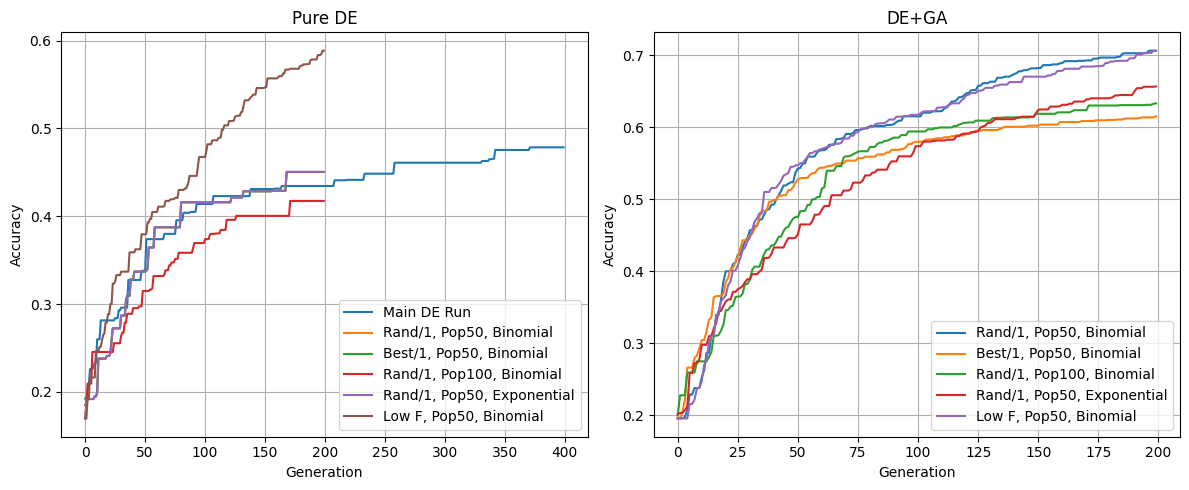

In [ ]:
st.subheader("Learning Curves")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for _, row in de_results_df.iterrows():
    ax1.plot(eval(row['History']) if isinstance(row['History'], str) else row['History'], label=row['Experiment'])
ax1.set_xlabel('Generation')
ax1.set_ylabel('Accuracy')
ax1.set_title('Pure DE')
ax1.legend()
ax1.grid(True)

for _, row in dega_results_df.iterrows():
    ax2.plot(eval(row['History']) if isinstance(row['History'], str) else row['History'], label=row['Experiment'])
ax2.set_xlabel('Generation')
ax2.set_ylabel('Accuracy')
ax2.set_title('DE+GA')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
st.pyplot(fig)

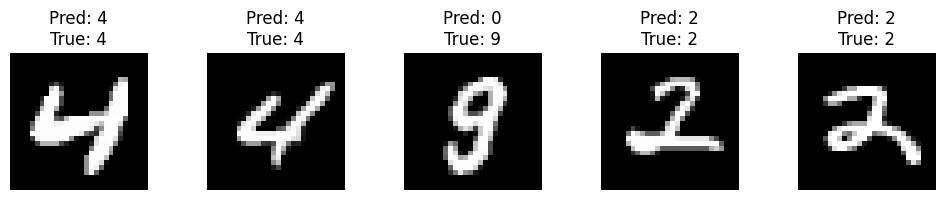

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (load x_test, y_test, best_ind/best model as 'nn') ...

indices = np.random.choice(len(x_test), 5)  # Select 5 random images
preds = nn.predict(x_test_flat[indices])  # Get predictions

# Display predictions
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_test[indices[i]], cmap='gray')
    ax.set_title(f"Pred: {preds[i]}\nTrue: {y_test[indices[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/sample_predictions.png')
plt.show()

Saved: project12_parameter_impact_de.png


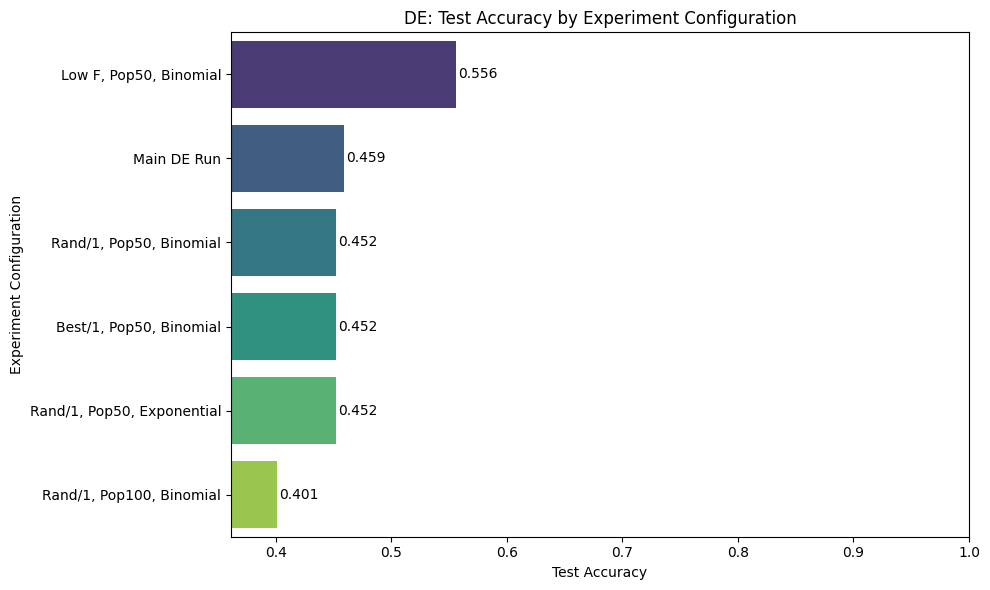

In [ ]:
# --- 3. Parameter Impact - DE ---
plt.figure(figsize=(10, max(6, 0.5 * len(de_results_df)))) # Adjust height based on num experiments
sns.barplot(data=de_results_df.sort_values('Test_Accuracy', ascending=False),
            x='Test_Accuracy', y='Experiment', palette='viridis', hue='Experiment', dodge=False)
plt.title('DE: Test Accuracy by Experiment Configuration')
plt.xlabel('Test Accuracy')
plt.ylabel('Experiment Configuration')
plt.xlim(de_results_df['Test_Accuracy'].min() * 0.9 if de_results_df['Test_Accuracy'].min() > 0 else 0, 1.0)
for index, row in de_results_df.sort_values('Test_Accuracy', ascending=False).reset_index().iterrows():
    plt.text(row['Test_Accuracy'] + 0.002, index, f"{row['Test_Accuracy']:.3f}", va='center')
plt.legend([],[], frameon=False) # Hide legend if using hue for coloring only
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/project12_parameter_impact_de.png')
print("Saved: project12_parameter_impact_de.png")
plt.show()

Saved: project12_parameter_impact_dega.png


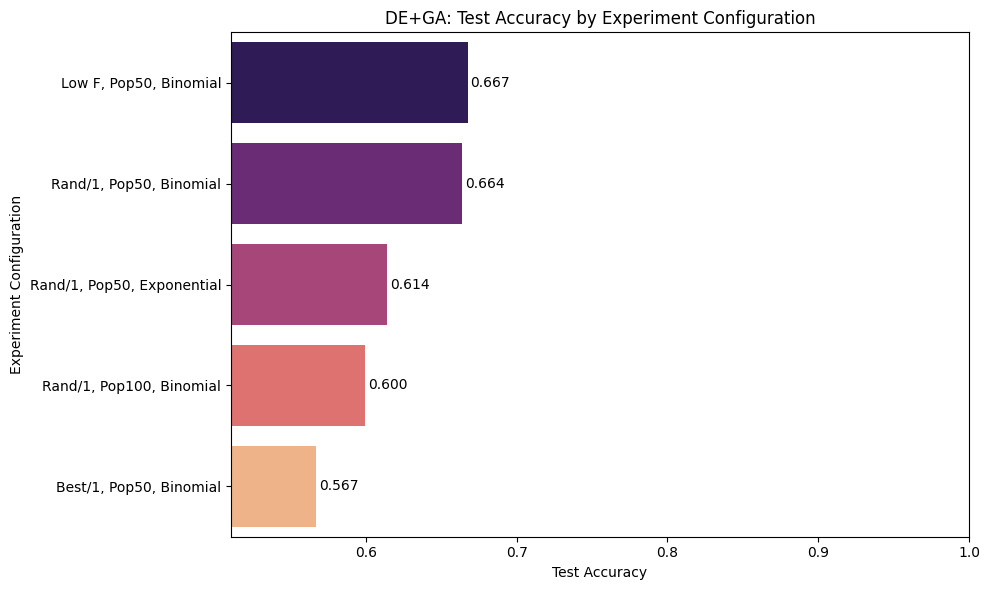

In [ ]:
# --- 4. Parameter Impact - DE+GA ---
plt.figure(figsize=(10, max(6, 0.5 * len(dega_results_df)))) # Adjust height
sns.barplot(data=dega_results_df.sort_values('Test_Accuracy', ascending=False),
            x='Test_Accuracy', y='Experiment', palette='magma', hue='Experiment', dodge=False)
plt.title('DE+GA: Test Accuracy by Experiment Configuration')
plt.xlabel('Test Accuracy')
plt.ylabel('Experiment Configuration')
plt.xlim(dega_results_df['Test_Accuracy'].min() * 0.9 if dega_results_df['Test_Accuracy'].min() > 0 else 0, 1.0)
for index, row in dega_results_df.sort_values('Test_Accuracy', ascending=False).reset_index().iterrows():
    plt.text(row['Test_Accuracy'] + 0.002, index, f"{row['Test_Accuracy']:.3f}", va='center')
plt.legend([],[], frameon=False) # Hide legend
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/project12_parameter_impact_dega.png')
print("Saved: project12_parameter_impact_dega.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


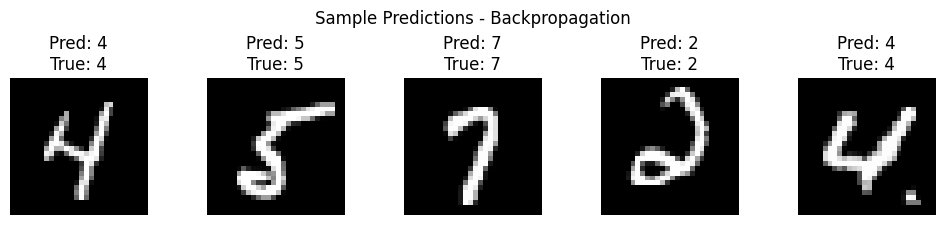

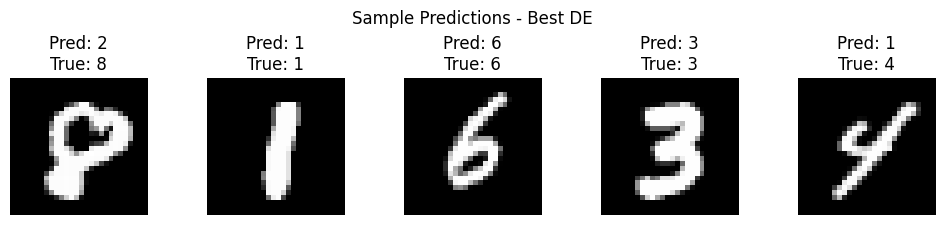

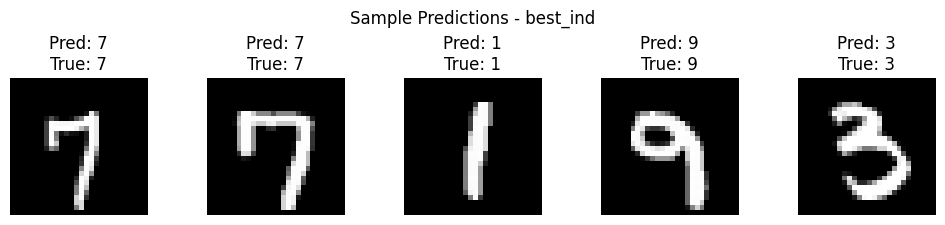

In [ ]:
def display_predictions(model_type, model, x_test, y_test, x_test_flat):
    indices = np.random.choice(len(x_test), 5)  # Select 5 random images
    if model_type == "Backpropagation":
        preds = np.argmax(model.predict(x_test[indices]), axis=1)
    else:  # DE or DE+GA
        nn = unflatten_weights(model)
        preds = nn.predict(x_test_flat[indices])

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_test[indices[i]], cmap='gray')
        ax.set_title(f"Pred: {preds[i]}\nTrue: {y_test[indices[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Sample Predictions - {model_type}", y=1.1)  # Add title above
    plt.show()

# Display predictions for each model
display_predictions("Backpropagation", model, x_test, y_test, x_test_flat)
display_predictions("Best DE", best_ind_main_de, x_test, y_test, x_test_flat)
display_predictions("best_ind", best_ind, x_test, y_test, x_test_flat)

In [ ]:
import pandas as pd

def get_best_dega_individual(csv_file_path):
    """
    Reads the DE+GA results CSV, identifies the experiment with the highest
    test accuracy, and returns its corresponding best individual.

    Args:
        csv_file_path (str): Path to the DE+GA results CSV file.

    Returns:
        numpy.ndarray: The best individual (weights) from the experiment with
                       the highest test accuracy.
    """

    # Read the DE+GA results CSV file
    dega_results_df = pd.read_csv(csv_file_path)

    # Find the index of the experiment with the highest test accuracy
    best_experiment_index = dega_results_df['Test_Accuracy'].idxmax()

    # Get the best individual from the best experiment
    # Assuming the "best_ind" column stores the best individual's weights
    best_ind = eval(dega_results_df.loc[best_experiment_index, 'best_ind'])

    return best_ind

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


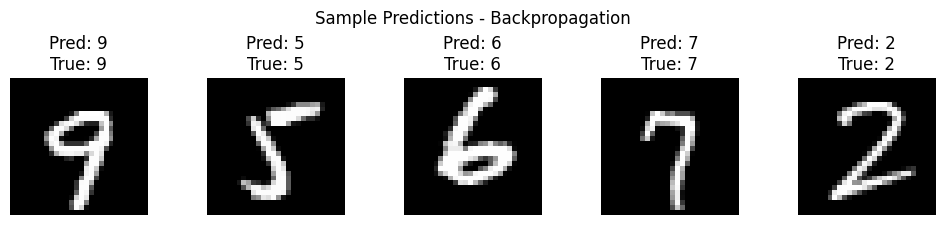

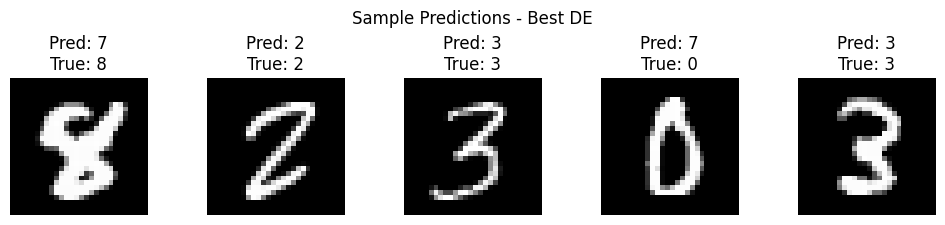

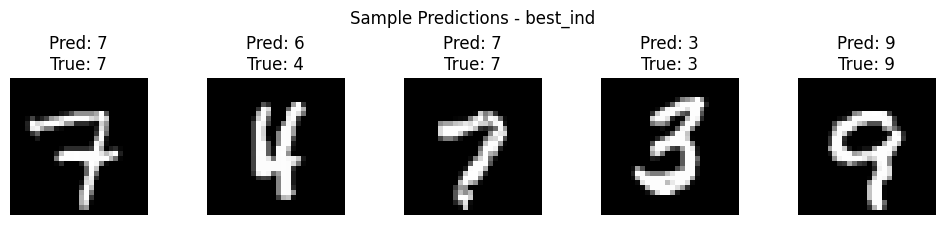

In [ ]:
def display_predictions(model_type, model, x_test, y_test, x_test_flat):
    indices = np.random.choice(len(x_test), 5)  # Select 5 random images
    if model_type == "Backpropagation":
        preds = np.argmax(model.predict(x_test[indices]), axis=1)
    else:  # DE or DE+GA
        nn = unflatten_weights(model)
        preds = nn.predict(x_test_flat[indices])

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_test[indices[i]], cmap='gray')
        ax.set_title(f"Pred: {preds[i]}\nTrue: {y_test[indices[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Sample Predictions - {model_type}", y=1.1)  # Add title above
    plt.show()

# Display predictions for each model
display_predictions("Backpropagation", model, x_test, y_test, x_test_flat)
display_predictions("Best DE", best_ind_main_de, x_test, y_test, x_test_flat)
display_predictions("best_ind", best_ind, x_test, y_test, x_test_flat)